### Импорт библиотек

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Импорт библиотек для кластеризации
# Документация: https://scikit-learn.org/stable/modules/clustering.html
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram

In [3]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Библиотека для построения Self-Organizing Maps: sklearn-som
# Документация библиотеки: https://sklearn-som.readthedocs.io/en/latest/index.html

# ! python3.7 -m pip install sklearn-som
from sklearn_som.som import SOM

## Загрузка данных

In [5]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'C:\\Users\\Frederik\\Desktop\\baseball.sas7bdat'

In [6]:
# Загружаем данные из SAS файла
df = pd.read_sas(file_path, encoding='latin-1')
# Пример данных
df.head()

,Name,Team,nAtBat,nHits,nHome,nRuns,nRBI,nBB,YrMajor,CrAtBat,...,CrBB,League,Division,Position,nOuts,nAssts,nError,Salary,Div,logSalary
0,"Allanson, Andy",Cleveland,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,...,14.0,American,East,C,446.0,33.0,20.0,NaN,AE,NaN
1,"Ashby, Alan",Houston,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,...,375.0,National,West,C,632.0,43.0,10.0,475.0,NW,6.163315
2,"Davis, Alan",Seattle,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,...,263.0,American,West,1B,880.0,82.0,14.0,480.0,AW,6.173786
3,"Dawson, Andre",Montreal,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,...,354.0,National,East,RF,200.0,11.0,3.0,500.0,NE,6.214608
4,"Galarraga, Andres",Montreal,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,...,33.0,National,East,1B,805.0,40.0,4.0,91.5,NE,4.516339


## Формирование признакового пространства

In [7]:
# Сформируем признаковое пространство:
# 1. YrMajor - число лет в лиге
# 2. Признаки с префиксом "n" - результаты 1986 года 
# 3. Признаки с префиксом "сr"  - результаты за всю карьеру

results_1986 = [c for c in df.columns if c[0] == "n"]
results_all = [c for c in df.columns if c[:2] == "Cr"]
sign_features = ['YrMajor'] + results_1986 + results_all

In [8]:
# Стандартизация признаков (вставьте свой код)
scaler = StandardScaler()

df_s = pd.DataFrame(scaler.fit_transform(df[sign_features]),
                                              columns = sign_features)

X = df_s.loc[:, sign_features]

## Часть 1: Иерархическая кластеризация и K-means

In [9]:
# Обучим модель Иерархической кластеризации
clustering = AgglomerativeClustering(distance_threshold = 0.0, n_clusters = None).fit(X)

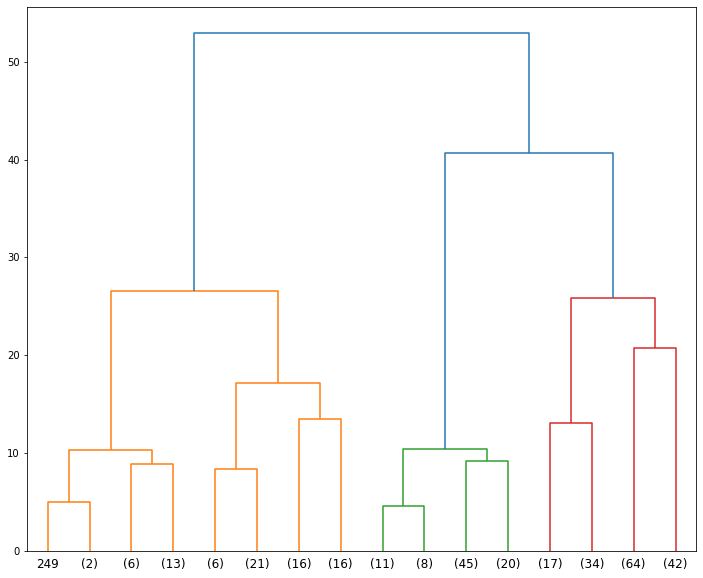

In [10]:
# Визуализация дендрограммы
def plot_dendrogram(model, **kwargs):
    # Создаем матрицу связности

    # Рассчитываем количество наблюдений в каждой вершине
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Лист
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    dendrogram(linkage_matrix, **kwargs, show_leaf_counts = True)

plot_dendrogram(clustering, truncate_mode="level", p=3)

[119.56929019 121.61624755 106.40848842 103.32934724  97.89965331
  91.89038421  86.86937369  82.04510413  78.50151567  74.86148088
  71.84610899  69.16062354  67.10744632  65.04326421  63.31060945
  61.88505654  60.64492495  59.64825449  58.60935539  57.26334176
  56.10526808  55.12288316  54.14371373  53.30876004  52.33380959
  51.4201882   50.59337619  49.84287008]


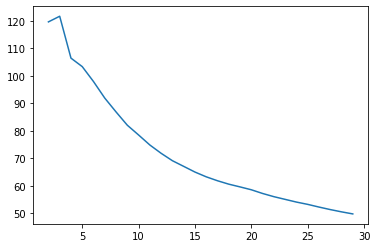

In [11]:
# Выберем число кластеров на основе псевдо критерия Фишера

def sum_dist_to_center(X):
    center = np.mean(X, axis = 0)
    return ((X - center)**2).values.sum()

def choose_num_clusters(X, max_clust = 30):
    N = X.shape[0]
    Q = sum_dist_to_center(X)
    pseudo_f = np.array([])
    for G in range(2, max_clust):
        clustering = AgglomerativeClustering(n_clusters = G).fit(X)
        W = 0
        for l in range(G):
            elems = X[clustering.labels_ == l]
            W += sum_dist_to_center(elems)
        fisher_stat = ((Q - W)/(G - 1))/(W/(N - G))
        pseudo_f = np.append(pseudo_f, fisher_stat)
    plt.plot(range(2, max_clust), pseudo_f)
    print(pseudo_f)
    return np.argmax(pseudo_f)+2

k = choose_num_clusters(X)
clustering = KMeans(n_clusters=k, random_state=0).fit(X)
label = clustering.labels_

### Ответить на следующие вопросы:

#### 1.   Сколько кластеров было выбрано на основе псевдо критерия Фишера?
#### 2.   Используя информацию из графика, ответьте на вопросы:
> 1.   Каково значение критерия для выбранного числа кластеров?
> 2.   А для числа кластеров на один больше и на один меньше?



1. Так как необходимо выбирать число кластеров с максимальным значением статистики PseudoF, то нам подходит количество кластеров равное 3.
2. При числе кластеров 3, значение PseudoF статистики равно 121.61624755. Для числа кластеров 2, значение PseudoF статистики равно 119.56929019, а для числа кластеров 4, значение PseudoF статистики равно 106.40848842.

## Часть 2: SOM

In [12]:
# Обучаем Self-Organizing Map с размером сетки 3 на 1
baseball_som = SOM(m=3, n=1, dim = X.shape[1])
baseball_som.fit(X.to_numpy())

labels = baseball_som.predict(X.to_numpy())

Text(0.5, 0, 'cluster')

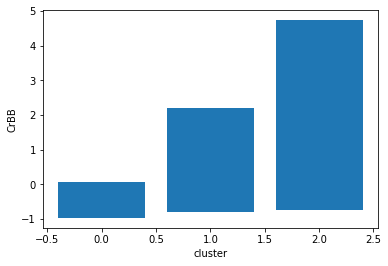

In [13]:
## Дополнительно #
## Значения признаков по кластерам удобно визуализировать с помощью barplot
## Нужное раскомментировать

## 1. В терминах matplotlib 
plt.bar(labels, X["CrBB"])
plt.ylabel("CrBB")
plt.xlabel("cluster")

<AxesSubplot:ylabel='CrBB'>

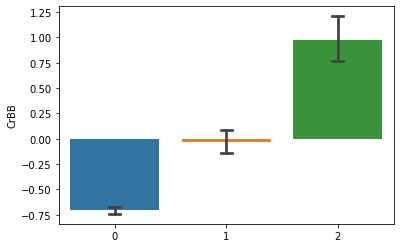

In [14]:
## 2. В терминах seaborn (+ доверительные интервалы)
sns.barplot(x = labels, y = X["CrBB"], capsize = 0.1)

## Часть 3: Анализ кластеров

## Построить модели:
> Для части 1: выбор количества кластеров на основе иерархической кластеризации с последующим обучение k-means

> Для части 2: обучение SOM с размером сетки 2 на 2 

## Ответить на следующие вопросы для каждой построенной модели
> Вариант I: Какой кластер содержит самых опытных игроков (переменная YrMajor)? 
> Вариант II: Какой кластер содержит самых успешных по хитам в 1986 году игроков (переменная nHits)?
> 1.	Сколько человек попало в этот кластер? 
> 2.    Как зовут самого типичного игрока в кластере вашего варианта (у него должно быть минимальное расстояние до центра вашего кластера)?

Для части 1. В качестве числа кластеров можно выбрать как 2, так и 3 кластера, так как "высота" ветвей для 2 кластеров и 3 примерно одинаковая. Для того, чтобы точно определится с числом кластеров, проведем иерархическую кластеризацию с дефолтными настройками и выберем какое число кластеров он сам подберет.

In [16]:
clustering = AgglomerativeClustering().fit(X)

In [17]:
clustering.n_clusters

2

Как видно, число кластеров равно 2. Тогда применим K-means с числом кластеров 2.

In [18]:
clustering = KMeans(n_clusters=2, random_state=0).fit(X)

Для того, чтобы определить самых успешных игроков в 1986 году необходимо найти центры каждого кластера и определить у центра какого кластера координата в плоскости nHits наибольшая.

In [19]:
centers = clustering.cluster_centers_
for i in range(len(centers)):
    print("В кластере номер", i + 1, ", координата, отвечающая за nHits, равна", centers[i][sign_features.index("nHits")])

В кластере номер 1 , координата, отвечающая за nHits, равна 0.4414145168792788
В кластере номер 2 , координата, отвечающая за nHits, равна -0.19596429224685438


Как можно заметить, в первом кластере в среднем величина nHits выше, чем во втором. А значит 1 кластер содержит в среднем самых успешных игрков в 1986 году. Теперь найдем число людей находящихся в этом кластере.

In [20]:
print("Число людей в 1 кластере:", len(clustering.labels_[clustering.labels_ == 0]))
print("Число людей во 2 кластере:",len(clustering.labels_[clustering.labels_ == 1]))

Число людей в 1 кластере: 99
Число людей во 2 кластере: 223


Число людей в 1 кластере равно 99, а во втором кластере 223. Далее найдем точку, которая ближе всего к центру кластера.

In [23]:
import math

minn = 1000
for i in range(len(clustering.labels_)):
    if clustering.labels_[i] == 0:
        print("Расстояние от игрока", df.iloc[[i]]["Name"].values[0][:-1], "до центра кластера равно", math.dist(centers[0], df_s.iloc[[i]].values[0][:-1]))
        if math.dist(centers[0], df_s.iloc[[i]].values[0][:-1]) < minn:
            minn = math.dist(centers[0], df_s.iloc[[i]].values[0][:-1])
            k = i
print("-------------------------------------------------------------")
print("Наименьшее расстояние до центра у игрока", df.iloc[[k]]["Name"].values[0])

Расстояние от игрока Dawson, Andr до центра кластера равно 1.907811570759375
Расстояние от игрока Thornton, Andr до центра кластера равно 2.630441345847325
Расстояние от игрока Trammell, Ala до центра кластера равно 4.369821065802274
Расстояние от игрока Bell, Budd до центра кластера равно 3.302420683985332
Расстояние от игрока Bochte, Bruc до центра кластера равно 2.8110380269476303
Расстояние от игрока Boone, Bo до центра кластера равно 2.6154600014214644
Расстояние от игрока Buckner, Bil до центра кластера равно 4.433186547597835
Расстояние от игрока Downing, Bria до центра кластера равно 2.835556569358359
Расстояние от игрока Grich, Bobb до центра кластера равно 3.5441568794697247
Расстояние от игрока Horner, Bo до центра кластера равно 4.4386274936138825
Расстояние от игрока Madlock, Bil до центра кластера равно 3.445911426316002
Расстояние от игрока Oglivie, Be до центра кластера равно 3.1595418598977525
Расстояние от игрока Russell, Bil до центра кластера равно 4.809513554051951

В результате оказалось, что самого типичного игрока зовут Lemon Chet.

Для части 2. Выберем в качестве размеров сетки значения 2 и 2. И обучим SOM с этой сеткой.

In [24]:
baseball_som = SOM(m=2, n=2, dim = X.shape[1])
baseball_som.fit(X.to_numpy())

labels = baseball_som.predict(X.to_numpy())

Посмотрим в каком кластере наибольшое значение величины nHits.

<AxesSubplot:ylabel='nHits'>

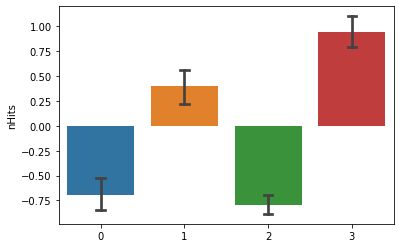

In [25]:
sns.barplot(x = labels, y = X["nHits"], capsize = 0.1)

Как можно заметить, в кластере номер 4 находятся в среднем самые успешные игроки 1986 года.

In [26]:
print("Число людей в 1 кластере:", len(labels[labels == 0]))
print("Число людей во 2 кластере:",len(labels[labels == 1]))
print("Число людей в 3 кластере:",len(labels[labels == 2]))
print("Число людей в 4 кластере:",len(labels[labels == 3]))

Число людей в 1 кластере: 42
Число людей во 2 кластере: 84
Число людей в 3 кластере: 109
Число людей в 4 кластере: 87


Как можно заметить, в 4 кластере находится 87 человек. Далее найдем самого типичного игрока нашего кластера.

In [27]:
df_s["lab"] = labels
center4 = df_s.loc[df_s["lab"] == 3].sum().values[:-1] / len(df_s.loc[df_s["lab"] == 3])

In [29]:
import math

minn = 1000
for i in range(len(labels)):
    if labels[i] == 3:
        print("Расстояние от игрока", df.iloc[[i]]["Name"].values[0], "до центра кластера равно", math.dist(center4, df_s.iloc[[i]].values[0][:-1]))
        if math.dist(center4, df_s.iloc[[i]].values[0][:-1]) < minn:
            minn = math.dist(centers[0], df_s.iloc[[i]].values[0][:-1])
            k = i
print("-------------------------------------------------------------")
print("Наименьшее расстояние до центра у игрока", df.iloc[[k]]["Name"].values[0])

Расстояние от игрока Davis, Alan до центра кластера равно 2.270197015133633
Расстояние от игрока Van Slyke, Andy до центра кластера равно 2.239981958316177
Расстояние от игрока Bonds, Barry до центра кластера равно 2.775601129463064
Расстояние от игрока Brenly, Bob до центра кластера равно 2.189614604297169
Расстояние от игрока Butler, Brett до центра кластера равно 2.878462558638489
Расстояние от игрока Diaz, Bo до центра кластера равно 2.3478051700180598
Расстояние от игрока Doran, Bill до центра кластера равно 2.93339372433804
Расстояние от игрока Jacoby, Brook до центра кластера равно 2.7510601061851316
Расстояние от игрока Brown, Chris до центра кластера равно 2.7378660034160003
Расстояние от игрока Davis, Chili до центра кластера равно 2.2133511753272206
Расстояние от игрока Maldonado, Candy до центра кластера равно 3.1698425776048147
Расстояние от игрока Ripken, Cal до центра кластера равно 3.6227610866420203
Расстояние от игрока Snyder, Cory до центра кластера равно 2.896637759

Как можно заметить, самого типичного игрока нашего кластера зовут Upshaw, Willie.